## Introduction to Ray Train

This notebook will walk you through the basics of distributed training with Ray Train and PyTorch.

<div class="alert alert-block alert-info">

<b> Roadmap</b>

<ul>
    <li><b>Part 0:</b> Introduction</li>
    <li><b>Part 1:</b> PyTorch introductory example</li>
    <li><b>Part 2:</b> Overview of Distributed Training with Ray Train</li>
    <li><b>Part 3:</b> Overview of the training loop in Ray Train</li>
    <li><b>Part 4:</b> Migrating the model and dataset to Ray Train</li>
    <li><b>Part 5:</b> Reporting metrics and checkpoints</li>
    <li><b>Part 6:</b> Launching the distributed training job</li>
    <li><b>Part 7:</b> Accessing training results</li>
</ul>
</div>

## 1. PyTorch introductory example (single GPU)

We will start by fitting a `ResNet18` model to an `MNIST` dataset.

Here is a diagram visualizing the single GPU training process:

<img src="https://anyscale-public-materials.s3.us-west-2.amazonaws.com/ray-ai-libraries/diagrams/single_gpu_pytorch_v3.png" width="800" >

At a high level, here is how our training loop in PyTorch looks like: 

In [17]:
from pathlib import Path

import torchmetrics
from torch.nn import CrossEntropyLoss
from torch.optim import Adam


def train_loop_torch(num_epochs: int = 2, batch_size: int = 128, local_path: str = "./checkpoints"):
    # Model, Loss, Optimizer
    loss_function = CrossEntropyLoss()
    model = load_model_torch()  # Later
    optimizer = Adam(model.parameters(), lr=1e-5)

    # Initialize the metric 
    acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to("cuda")

    # Load the data loader
    data_loader = build_data_loader_torch(batch_size=batch_size)  # Later

    # Training loop
    for epoch in range(num_epochs):
        for images, labels in data_loader:
            # Move the data to the GPU
            images, labels = images.to("cuda"), labels.to("cuda")

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = loss_function(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

            # Update the metric
            acc(outputs, labels)
        
        # Report the metrics
        metrics = report_metrics_torch(loss=loss, accuracy=acc.compute(), epoch=epoch)  # Later
        
        # Reset the metric
        acc.reset()

        # Save the checkpoint and metrics
        Path(local_path).mkdir(parents=True, exist_ok=True)
        save_checkpoint_and_metrics_torch(metrics=metrics, model=model, local_path=local_path)  # Later


### Build and load our model on a single GPU

In [16]:
import torch
from torchvision.models import resnet18


def build_resnet18():
    model = resnet18(num_classes=10)
    model.conv1 = torch.nn.Conv2d(
        in_channels=1, # grayscale (one channel) MNIST images
        out_channels=64,
        kernel_size=(7, 7),
        stride=(2, 2),
        padding=(3, 3),
        bias=False,
    )
    return model


def load_model_torch() -> torch.nn.Module:
    model = build_resnet18()
    # Move to the single GPU device
    model.to("cuda")
    return model

### Loading and visualizing MNIST data

In [18]:
from torchvision.datasets import MNIST

dataset = MNIST(root="./data", train=True, download=True)

Let's display the first 10 images, with the corresponding labels:

/home/ray/anaconda3/lib/python3.11/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/ray/anaconda3/lib/python3.11/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


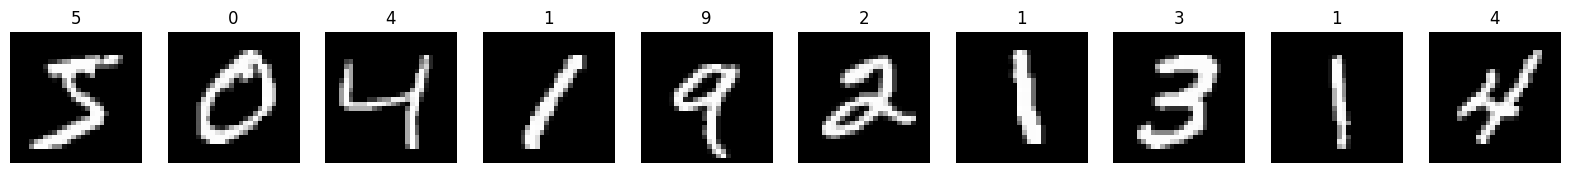

In [30]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(dataset.train_data[i], cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(dataset.train_labels[i].item())

### Defining a data loader

In [6]:
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader


def build_data_loader_torch(batch_size: int) -> DataLoader:
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    dataset = MNIST(root="./data", train=True, download=True, transform=transform)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return train_loader

### Reporting metrics

In [33]:
def report_metrics_torch(loss: torch.Tensor, accuracy: torch.Tensor, epoch: int) -> None:
    metrics = {"loss": loss.item(), "epoch": epoch, "accuracy": accuracy.item()}
    print(metrics)
    return metrics

### Saving a checkpoint in a local directory

In [19]:
import os
import csv


def save_checkpoint_and_metrics_torch(metrics: dict[str, float], model: torch.nn.Module, local_path: str) -> None:
    # Save the metrics
    with open(os.path.join(local_path, "metrics.csv"), "a") as f:
        writer = csv.writer(f)
        writer.writerow(metrics.values())

    # Save the model
    checkpoint_path = os.path.join(local_path, "model.pt")
    torch.save(model.state_dict(), checkpoint_path)

### Scheduling the training loop on a single GPU

In [35]:
import datetime

timestamp = datetime.datetime.now(datetime.UTC).strftime("%Y-%m-%d_%H-%M-%S")
local_path = f"/mnt/local_storage/single_gpu_mnist/torch_{timestamp}/"

train_loop_torch(
    num_epochs=2, 
    local_path=local_path
)

{'loss': 0.2784426808357239, 'epoch': 0, 'accuracy': 0.8147535920143127}
{'loss': 0.10893423855304718, 'epoch': 1, 'accuracy': 0.9506543874740601}


Let's inspect the produced checkpoints and metrics

In [36]:
!ls -l {local_path}

total 43732
-rw-r--r-- 1 ray users       83 Nov 22 09:26 metrics.csv
-rw-r--r-- 1 ray users 44773570 Nov 22 09:26 model.pt


In [37]:
import pandas as pd


metrics = pd.read_csv(
    os.path.join(local_path, "metrics.csv"),
    header=None,
    names=["loss", "epoch", "accuracy"],
)
metrics

,loss,epoch,accuracy
0,0.278443,0,0.814754
1,0.108934,1,0.950654


We can also load our produced model checkpoint

In [38]:
loaded_model = build_resnet18()
loaded_model.load_state_dict(torch.load(os.path.join(local_path, "model.pt")))
loaded_model.eval()

/tmp/ipykernel_52702/470834418.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(os.path.join(local_path, "model.pt")))


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We can the proceed to generate predictions on the first 10 images of the MNIST dataset.

/home/ray/anaconda3/lib/python3.11/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


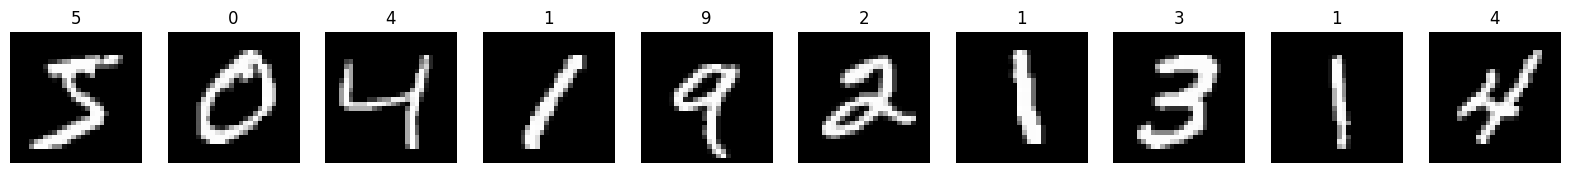

In [39]:
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axs[i].imshow(dataset.train_data[i], cmap="gray")
    axs[i].axis("off")
    with torch.no_grad():
        normalized = Normalize((0.5,), (0.5,))(ToTensor()(dataset[i][0]))
        prediction = loaded_model(normalized.unsqueeze(0)).argmax()
    axs[i].set_title(prediction.item())

## 2. Distributed Data Parallel Training with Ray Train and PyTorch (multiple GPUs)

- Let's now consider the case where we have a very large dataset of images that would take a long time to train on a single GPU.
- We would now like to scale this training job to run on multiple GPUs. 
- Here is a diagram visualizing the desired distributed data-parallel training process

<img src="https://anyscale-public-materials.s3.us-west-2.amazonaws.com/ray-ai-libraries/diagrams/multi_gpu_pytorch_v4.png" width="1000" >




## 3. Overview of the training loop in Ray Train

Let's see how this data-parallel training loop will look like with Ray Train and PyTorch.

In [7]:
def train_loop_ray_train(config: dict):  # pass in hyperparameters in config
    loss_function = CrossEntropyLoss()
    
    # New: Use Ray Train to wrap the original PyTorch model
    model = load_model_ray_train()

    # Initialize Adam optimizer
    optimizer = Adam(model.parameters(), lr=1e-5)
    
    # New: Calculate the batch size for each worker (batch size / num workers)
    batch_size = config["global_batch_size"] // ray.train.get_context().get_world_size()
    
    # New: Use Ray Train to wrap the data loader as a distributed sampler
    data_loader = build_data_loader_ray_train(batch_size=batch_size) 
    
    acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(model.device)

    for epoch in range(config["num_epochs"]):
        # Ensure data is on the correct device for each epoch
        data_loader.sampler.set_epoch(epoch)

        # New: images, labels are now sharded,
        # Gradients are accumulated across the workers
        for images, labels in data_loader:
            outputs = model(images)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()
            acc(outputs, labels)

        # accuracy is now aggregated across the workers
        accuracy = acc.compute()

        # Use Ray Train to report metrics
        metrics = print_metrics_ray_train(loss, accuracy, epoch)

        # Use Ray Train to save checkpoint and metrics
        save_checkpoint_and_metrics_ray_train(model, metrics)
        acc.reset() 

### Configure scale and GPUs
Outside of our training function, we create a `ScalingConfig` object to configure:

- `num_workers`: The number of distributed training worker processes.
- `use_gpu`: Whether each worker should use a GPU (or CPU).


See [docs on configuring scale and GPUs](https://docs.ray.io/en/latest/train/user-guides/using-gpus.html) for more details.

In [8]:
from ray.train import ScalingConfig

scaling_config = ScalingConfig(num_workers=2, use_gpu=True)

Here is a high-level architecture of how Ray Train works:

<img src="https://docs.ray.io/en/latest/_images/overview.png" width=600>

#### Key points
- The scaling config specifies the number of training workers.
- A trainer actor process is launched that oversees the training workers.

## 4. Migrating the model and dataset to Ray Train

Use the `ray.train.torch.prepare_model()` utility function to:

- Automatically move your model to the correct device.
- Wrap the model in pytorch's `DistributedDataParallel`.

To learn more about the `prepare_model()` function, see the [API reference](https://docs.ray.io/en/latest/train/api/doc/ray.train.torch.prepare_model.html#ray-train-torch-prepare-model).

In [9]:
import torch

def load_model_ray_train() -> torch.nn.Module:
    model = build_resnet18()
    # Instead of model = model.to("cuda")
    model = ray.train.torch.prepare_model(model) 
    return model

Use the `ray.train.torch.prepare_data_loader()` utility function, to:

- Automatically moves the batches to the right device.
- Wrap the data loader with pytorch's `DistributedSampler`.

To learn more about the `prepare_data_loader()` function, see the [API reference](https://docs.ray.io/en/latest/train/api/doc/ray.train.torch.prepare_data_loader.html#ray-train-torch-prepare-data-loader).

In [10]:
def build_data_loader_ray_train(batch_size: int) -> DataLoader:
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    train_data = MNIST(root="./data", train=True, download=True, transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

    # Add DistributedSampler to the DataLoader
    train_loader = ray.train.torch.prepare_data_loader(train_loader)
    return train_loader

<div class="alert alert-block alert-warning">
<b> Note</b> that this step isn’t necessary if you are integrating your Ray Train implementaiton with Ray Data.
</div>

## 5. Reporting checkpoints and metrics

To monitor progress, we can continue to print/log metrics as before. This time we chose to only do so for the first worker.

In [24]:
def print_metrics_ray_train(
    loss: torch.Tensor, accuracy: torch.Tensor, epoch: int
) -> None:
    metrics = {"loss": loss.item(), "accuracy": accuracy.item(), "epoch": epoch}
    if ray.train.get_context().get_world_rank() == 0:
        print(metrics)
    return metrics

we will report intermediate metrics and checkpoints using the `ray.train.report` utility function.

In [23]:
def save_checkpoint_and_metrics_ray_train(
    model: torch.nn.Module, metrics: dict[str, float]
) -> None:
    with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
        torch.save(
            model.module.state_dict(),  # note the .module to unwrap the DistributedDataParallel
            os.path.join(temp_checkpoint_dir, "model.pt"),
        )
        ray.train.report(  # use ray.train.report to save the metrics and checkpoint
            metrics,  # train.report will only save worker rank 0's metrics
            checkpoint=ray.train.Checkpoint.from_directory(temp_checkpoint_dir),
        )

Here is the lifecycle of a checkpoint from being created using a local path to being uploaded to persistent storage.

<img src="https://docs.ray.io/en/latest/_images/checkpoint_lifecycle.png" width=800>


Given it is the same model across all workers, we can instead only build the checkpoint on worker of rank 0. Note that we will still need to call `ray.train.report` on all workers to ensure that the training loop is synchronized.

In [22]:
import tempfile
import ray

def save_checkpoint_and_metrics_ray_train(model: torch.nn.Module, metrics: dict[str, float]):
    with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
        checkpoint = None
        # On the first worker
        if ray.train.get_context().get_world_rank() == 0:
            # Save PyTorch checkpoints locally
            torch.save(model.module.state_dict(), os.path.join(temp_checkpoint_dir, "model.pt"))
            # Convert to Ray Train checkpoint
            checkpoint = ray.train.Checkpoint.from_directory(temp_checkpoint_dir)

        # Report checkpoint
        ray.train.report(
            metrics,
            checkpoint=checkpoint,
        )

For an in-depth guide on saving checkpoints and metrics, see the [docs](https://docs.ray.io/en/latest/train/user-guides/checkpoints.html).

## 6. Launching the distributed training job

<img src="https://anyscale-public-materials.s3.us-west-2.amazonaws.com/ray-ai-libraries/diagrams/multi_gpu_pytorch_annotated_v5.png" width="1000" >

Let's proceed to launch the distributed training job.

### Configure persistent storage
Create a `RunConfig` object to specify the path where results (including checkpoints and artifacts) will be saved.


In [11]:
from ray.train import RunConfig

storage_path = "/mnt/cluster_storage/ray-summit-2024-training/"
run_config = RunConfig(storage_path=storage_path, name="distributed-mnist-resnet18")

### Launching a distributed training job with a `TorchTrainer`.

In [12]:
from ray.train.torch import TorchTrainer


trainer = TorchTrainer(
    train_loop_ray_train,
    scaling_config=scaling_config,
    run_config=run_config,
    train_loop_config={"num_epochs": 2, "global_batch_size": 128},
)


2024-11-22 11:46:34,891	INFO worker.py:1596 -- Connecting to existing Ray cluster at address: 10.0.25.5:6379...
2024-11-22 11:46:34,898	INFO worker.py:1772 -- Connected to Ray cluster. View the dashboard at https://session-wun39fg7yb3g9682a8fejskwz3.i.anyscaleuserdata.com 
2024-11-22 11:46:35,055	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_c0d0f875c8f886002dd044911a6c5a1d734f1c8c.zip' (63.64MiB) to Ray cluster...
2024-11-22 11:46:35,772	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_c0d0f875c8f886002dd044911a6c5a1d734f1c8c.zip'.


(autoscaler +1h34m20s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.


Calling `trainer.fit()` will start the run and block until it completes.

In [25]:
result = trainer.fit()

2024-11-22 11:49:35,784	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2024-11-22 11:49:35 (running for 00:00:00.11)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 2.0/2 GPUs (0.0/2.0 anyscale/accelerator_shape:1xT4, 0.0/2.0 accelerator_type:T4, 0.0/2.0 anyscale/provider:aws, 0.0/2.0 anyscale/region:us-west-2)
Result logdir: /tmp/ray/session_2024-11-22_06-00-05_069833_2422/artifacts/2024-11-22_11-49-35/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2024-11-22 11:49:40 (running for 00:00:05.12)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 2.0/2 GPUs (0.0/2.0 anyscale/accelerator_shape:1xT4, 0.0/2.0 accelerator_type:T4, 0.0/2.0 anyscale/provider:aws, 0.0/2.0 anyscale/region:us-west-2)
Result logdir: /tmp/ray/session_2024-11-22_06-00-05_069833_2422/artifacts/2024-11-22_11-49-35/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-11-22 11:49:45 (running for 00:00:10.1

(RayTrainWorker pid=30603, ip=10.0.4.138) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(RayTrainWorker pid=30603, ip=10.0.4.138) Failed to download (trying next):
(RayTrainWorker pid=30603, ip=10.0.4.138) HTTP Error 403: Forbidden
(RayTrainWorker pid=30603, ip=10.0.4.138) 
(RayTrainWorker pid=129887) 
(RayTrainWorker pid=129887) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to ./data/MNIST/raw/train-images-idx3-ubyte.gz


  1%|          | 98304/9912422 [00:00<00:11, 875444.52it/s]


(RayTrainWorker pid=129887) Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw
(RayTrainWorker pid=129887) 
(RayTrainWorker pid=30603, ip=10.0.4.138) 
(RayTrainWorker pid=129887) 
(RayTrainWorker pid=30603, ip=10.0.4.138) 
(RayTrainWorker pid=129887) 
(RayTrainWorker pid=30603, ip=10.0.4.138) 
(RayTrainWorker pid=129887) 
(RayTrainWorker pid=30603, ip=10.0.4.138) 


(RayTrainWorker pid=129887) [rank1]:[W1122 11:49:45.059424410 Utils.hpp:110] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function operator()) [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
100%|██████████| 1648877/1648877 [00:00<00:00, 4100558.59it/s]


(RayTrainWorker pid=129887) 
(RayTrainWorker pid=30603, ip=10.0.4.138) 
(RayTrainWorker pid=129887) 
(RayTrainWorker pid=30603, ip=10.0.4.138) 
(RayTrainWorker pid=30603, ip=10.0.4.138) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz [repeated 15x across cluster]
(RayTrainWorker pid=129887) 


(RayTrainWorker pid=129887) Moving model to device: cuda:0
(RayTrainWorker pid=129887) Wrapping provided model in DistributedDataParallel.


(RayTrainWorker pid=30603, ip=10.0.4.138) 
(RayTrainWorker pid=30603, ip=10.0.4.138) {'loss': 0.30887049436569214, 'accuracy': 0.7834368348121643, 'epoch': 0}
(RayTrainWorker pid=30603, ip=10.0.4.138) Failed to download (trying next): [repeated 7x across cluster]
(RayTrainWorker pid=30603, ip=10.0.4.138) HTTP Error 403: Forbidden [repeated 7x across cluster]
(RayTrainWorker pid=30603, ip=10.0.4.138) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz [repeated 7x across cluster]
(RayTrainWorker pid=30603, ip=10.0.4.138) Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw [repeated 7x across cluster]


(RayTrainWorker pid=30603, ip=10.0.4.138) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/ray-summit-2024-training/distributed-mnist-resnet18/TorchTrainer_d89d0_00000_0_2024-11-22_11-49-35/checkpoint_000000)
 38%|███▊      | 622592/1648877 [00:00<00:00, 2175211.11it/s] [repeated 13x across cluster]


(RayTrainWorker pid=30603, ip=10.0.4.138) {'loss': 0.06367093324661255, 'accuracy': 0.9425080418586731, 'epoch': 1}


(RayTrainWorker pid=129887) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/ray-summit-2024-training/distributed-mnist-resnet18/TorchTrainer_d89d0_00000_0_2024-11-22_11-49-35/checkpoint_000001) [repeated 2x across cluster]


2024-11-22 11:50:29,707	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/cluster_storage/ray-summit-2024-training/distributed-mnist-resnet18' in 0.0255s.
2024-11-22 11:50:29,709	INFO tune.py:1041 -- Total run time: 53.92 seconds (53.89 seconds for the tuning loop).


== Status ==
Current time: 2024-11-22 11:50:29 (running for 00:00:53.91)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 2.0/2 GPUs (0.0/2.0 anyscale/region:us-west-2, 0.0/2.0 accelerator_type:T4, 0.0/2.0 anyscale/provider:aws, 0.0/2.0 anyscale/accelerator_shape:1xT4)
Result logdir: /tmp/ray/session_2024-11-22_06-00-05_069833_2422/artifacts/2024-11-22_11-49-35/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 TERMINATED)




## 7. Accessing the training results

After training completes, a `Result` object is returned which contains information about the training run, including the metrics and checkpoints reported during training.

In [26]:
result

Result(
  metrics={'loss': 0.06367093324661255, 'accuracy': 0.9425080418586731, 'epoch': 1},
  path='/mnt/cluster_storage/ray-summit-2024-training/distributed-mnist-resnet18/TorchTrainer_d89d0_00000_0_2024-11-22_11-49-35',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/mnt/cluster_storage/ray-summit-2024-training/distributed-mnist-resnet18/TorchTrainer_d89d0_00000_0_2024-11-22_11-49-35/checkpoint_000001)
)

We can check the metrics produced by the training job.

In [27]:
result.metrics_dataframe

,loss,accuracy,epoch,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/train_loop_config/num_epochs,config/train_loop_config/global_batch_size
0,0.308870,0.783437,0,1732276209,checkpoint_000000,True,False,1,d89d0_00000,2024-11-22_11-50-09,29.641551,29.641551,30551,ip-10-0-4-138,10.0.4.138,29.641551,1,2,128
1,0.063671,0.942508,1,1732276227,checkpoint_000001,True,False,2,d89d0_00000,2024-11-22_11-50-27,18.365191,48.006742,30551,ip-10-0-4-138,10.0.4.138,48.006742,2,2,128


We can also take the latest checkpoint and load it to inspect the model.

In [28]:
ckpt = result.checkpoint
with ckpt.as_directory() as ckpt_dir:
    model_path = os.path.join(ckpt_dir, "model.pt")
    loaded_model_ray_train = build_resnet18()
    state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)
    loaded_model_ray_train.load_state_dict(state_dict)
    loaded_model_ray_train.eval()

loaded_model_ray_train

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

To learn more about the training results, see this [docs](https://docs.ray.io/en/latest/train/user-guides/results.html) on inspecting the training results.

We can then proceed to generate predictions using the loaded model:

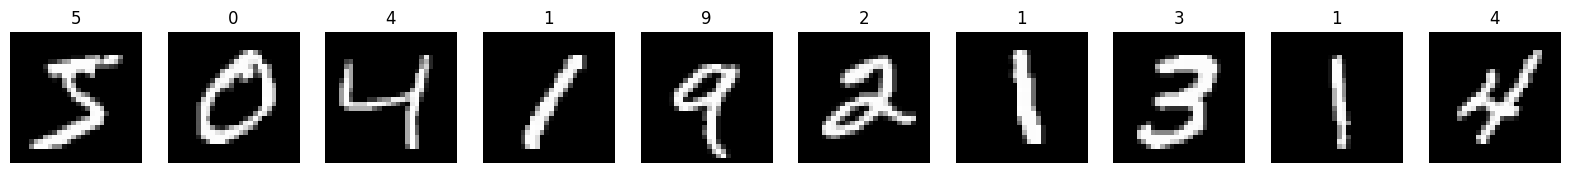

In [31]:
fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(dataset.train_data[i], cmap="gray")
    axs[i].axis("off")
    with torch.no_grad():
        normalized = Normalize((0.5,), (0.5,))(ToTensor()(dataset[i][0]))
        prediction = loaded_model_ray_train(normalized.unsqueeze(0)).argmax()
    axs[i].set_title(prediction.item())
    

<div class="alert alert-block alert-info">

### Activity: Update the training loop to compute the area under the curve of ROC (AUROC)

1. Update the training loop `train_loop_ray_train` to compute the AUROC metric.
2. Update the `print_metrics_ray_train` function to include the AUROC metric.
3. Save the AUROC metric in the `save_checkpoint_and_metrics_ray_train` function.

Use the following code snippets to guide you:

```python
# Hint: Update the print function to include AUROC
def print_metrics_ray_train(...):
    ...

def train_loop_ray_train(config):
    # Hint: Update the training loop to compute AUROC

trainer = TorchTrainer(
    train_loop_ray_train,
    scaling_config=scaling_config,
    run_config=run_config,
    train_loop_config={"num_epochs": 2, "global_batch_size": 128},
)
result = trainer.fit()
result.metrics_dataframe
```

</div>

In [ ]:
# Write your solution here


<div class="alert alert-block alert-info">

<details>

<summary> Click here to see the solution </summary>

```python
def print_metrics_ray_train(loss, accuracy, auroc):
    metrics = {
        "loss": loss.item(),
        "accuracy": accuracy.item(),
        "auroc": auroc.item(),
    }
    if ray.train.get_context().get_world_rank() == 0:
        print(
            f"Loss: {loss.item()}, Accuracy: {accuracy.item()}, AUROC: {auroc.item()}"
        )
    return metrics


def train_loop_ray_train(config):
    loss_function = CrossEntropyLoss()
    model = load_model_ray_train()
    optimizer = Adam(model.parameters(), lr=1e-5)

    global_batch_size = config["global_batch_size"]
    batch_size = global_batch_size // ray.train.get_context().get_world_size()
    data_loader = build_data_loader_ray_train(batch_size=batch_size)

    acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(model.device)
    # Add AUROC metric
    auroc = torchmetrics.AUROC(task="multiclass", num_classes=10).to(model.device)

    for epoch in range(config["num_epochs"]):
        data_loader.sampler.set_epoch(epoch)

        for images, labels in data_loader:
            outputs = model(images)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc(outputs, labels)
            auroc(outputs, labels)

        metrics = print_metrics_ray_train(
            loss, acc.compute(), auroc.compute()
        )
        save_checkpoint_and_metrics_ray_train(model, metrics)
        acc.reset()
        auroc.reset()

trainer = TorchTrainer(
    train_loop_ray_train,
    scaling_config=scaling_config,
    run_config=run_config,
    train_loop_config={"num_epochs": 2, "global_batch_size": 128},
)
result = trainer.fit()
print(result.metrics_dataframe)
```

</details>

## 8. Ray Train in Production

Here are some use-cases of using Ray Train in production:
1. Canva uses Ray Train + Ray Data to cut down Stable Diffusion training costs by 3.7x. Read this [Anyscale blog post here](https://www.anyscale.com/blog/scalable-and-cost-efficient-stable-diffusion-pre-training-with-ray) and the [Canva  case study here](https://www.anyscale.com/resources/case-study/how-canva-built-a-modern-ai-platform-using-anyscale)
2. Anyscale uses Ray Train + Deepspeed to finetune language models. Read more [here](https://github.com/ray-project/ray/tree/master/doc/source/templates/04_finetuning_llms_with_deepspeed).


In [ ]:
# Run this cell for file cleanup 
!rm -rf /mnt/cluster_storage/single_gpu_mnist